# Brain Tumor Classification
La diagnosi precoce e la classificazione dei tumori cerebrali è un importante ambito di ricerca nel campo medico.
Secondo l'Organizzazione Mondiale della Sanità (OMS) l'applicazione di approcci di *deep learning* sta fornendo soluzioni di grande impatto per la corretta diagnosi del tumore al cervello, il rilevamento, l'identificazione della posizione del tumore al cervello e la classificazione del tumore sulla base di malignità, grado e tipo. In particolare la *Convolutional Neural Network (CNN)* è un ottimo strumento per la classificazione e il rilevamento dei tumori.

# Informazioni sul dataset
Questo set di dati contiene 7022 immagini di risonanze magnetiche del cervello umano che sono classificate in 4 classi: 
- glioma 
- meningioma 
- nessun tumore
- ipofisi.

# Convolutional Neural Network (CNN)
Nell'apprendimento automatico, una rete neurale convoluzionale è un tipo di rete neurale artificiale in cui il pattern di connettività tra i neuroni è ispirato dall'organizzazione della corteccia visiva animale, i cui neuroni individuali sono disposti in maniera tale da rispondere alle regioni di sovrapposizione che tassellano il campo visivo. Le reti convoluzionali sono ispirate da processi biologici e sono variazioni di percettroni multistrato progettate per usare al minimo la pre-elaborazione. Hanno diverse applicazioni nel riconoscimento di immagini e video, nell'elaborazione del linguaggio naturale e, recentemente, in bioinformatica.

In [1]:
#load the libraries
import tensorflow.keras
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
from tensorflow import keras

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix,roc_auc_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_dir = 'archive/Training/'
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)
random.shuffle(train_paths)

#print(train_paths[0])
len(train_paths)

5712

In [3]:
test_dir = 'archive/Testing/'
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
random.shuffle(test_paths)

#print(trest_paths[0])
len(test_paths)

1311

In [4]:
train_data = []
train_labels = []

test_data = []
test_labels = []

for imagePath in train_paths:
    # extract the class label
    label = imagePath.split('/')[-2]
    
    # load the image 
    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)
    image = np.array(image)/255.0
    
    # update training data
    train_data.append(image)
    train_labels.append(label)

for imagePath in test_paths:
    # extract the class label
    label = imagePath.split('/')[-2]
    
    # load the image 
    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)
    image = np.array(image)/255.0
    
    # update testing data
    test_data.append(image)
    test_labels.append(label)
    

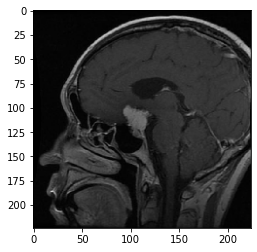

In [5]:
plt.imshow(train_data[0])

In [6]:
def convert_data_labels(data,labels):
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)
  labels_to_index=dict(zip(le.classes_, le.transform(le.classes_)))
  labels = to_categorical(labels)
  return  data,labels,labels_to_index

In [7]:
train_data,train_labels,labels_to_index = convert_data_labels(train_data,train_labels)
test_data,test_labels,labels_to_index= convert_data_labels(test_data,test_labels)

In [8]:
labels_to_index

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [9]:
index_to_labels={}
for label,value in enumerate(labels_to_index):
    index_to_labels[label]=value

In [10]:
index_to_labels

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# CNN architectures
Le architetture CNN tre tipi principali di strati, che sono:
- Strato convoluzionale
- Strato di pooling
- Livello completamente connesso (FC).

Lo strato convoluzionale è il primo strato di una rete convoluzionale. Mentre gli strati convoluzionali possono essere seguiti da strati convoluzionali aggiuntivi o strati di pooling, lo strato completamente connesso è lo strato finale. Ad ogni livello, la CNN aumenta nella sua complessità, identificando porzioni maggiori dell'immagine. I livelli precedenti si concentrano su funzioni semplici, come colori e bordi. Man mano che i dati dell'immagine avanzano attraverso i livelli della CNN, inizia a riconoscere elementi o forme più grandi dell'oggetto fino a identificare finalmente l'oggetto previsto.
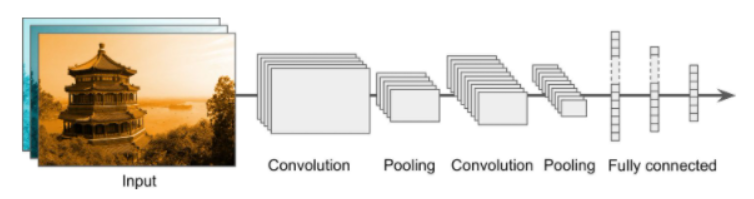

# ResNet
ResNet e' un'architettura estremamente profonda composta da 152 layers. Vengono inoltre inserite delle skip connection: l'output di un livello viene aggiungto all'output di un altro livello posizionato piu' in "alto" nell'architettura.
Aggiungendo le skip connection la rete puo' apprendere nonostante alcuni moduli, detti residual unit non abbiano ancora imparato. Ricordiamo che imparare vuol dire aggiornare i pesi.
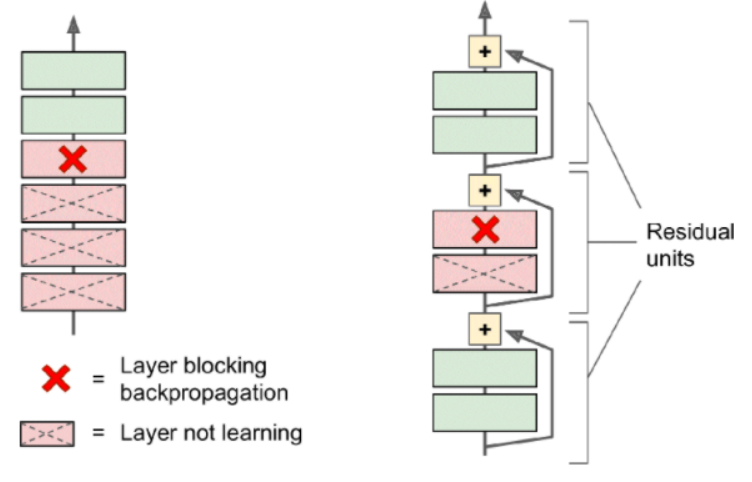

In [11]:
resnet_model = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Set all layers to non-trainable
for layer in resnet_model.layers[:171]:
    layer.trainable = False

for layer in resnet_model.layers[171:]:
    layer.trainable = True

In [12]:
# define the model
model = Sequential([
    Input(shape=(224,224,3)),
    resnet_model,
    Flatten(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax'), # num labels = 4
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36,433,412
Trainable params: 13,900,420
No

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy','AUC'])

In [14]:
BS=32

# train datagen
train_datagen = ImageDataGenerator(
#                   rescale = 1/255,
                  validation_split=0.25
)


# test datagen
test_datagen = ImageDataGenerator(
#                     rescale = 1/255
    
)

train_gen = train_datagen.flow(train_data, train_labels, batch_size=BS,subset="training")

val_gen = train_datagen.flow(train_data, train_labels, batch_size=BS,subset="validation")

test_gen = train_datagen.flow(test_data, test_labels, batch_size=BS)

In [15]:
#training
history=model.fit(train_gen, 
          epochs=15,
          validation_data=val_gen
         )

Epoch 1/15
134/134 [==============================] - 475s 4s/step - loss: 0.8938 - accuracy: 0.6457 - auc: 0.8690 - val_loss: 0.9420 - val_accuracy: 0.5889 - val_auc: 0.8590
Epoch 2/15
134/134 [==============================] - 445s 3s/step - loss: 0.5993 - accuracy: 0.7677 - auc: 0.9373 - val_loss: 0.6487 - val_accuracy: 0.7633 - val_auc: 0.9373
Epoch 3/15
134/134 [==============================] - 465s 3s/step - loss: 0.5431 - accuracy: 0.7824 - auc: 0.9482 - val_loss: 0.5416 - val_accuracy: 0.7941 - val_auc: 0.9514
Epoch 4/15
134/134 [==============================] - 473s 4s/step - loss: 0.4786 - accuracy: 0.8067 - auc: 0.9594 - val_loss: 0.6454 - val_accuracy: 0.7311 - val_auc: 0.9305
Epoch 5/15
134/134 [==============================] - 459s 3s/step - loss: 0.4602 - accuracy: 0.8182 - auc: 0.9621 - val_loss: 0.5169 - val_accuracy: 0.8032 - val_auc: 0.9539
Epoch 6/15
134/134 [==============================] - 447s 3s/step - loss: 0.4002 - accuracy: 0.8434 - auc: 0.9712 - val_loss

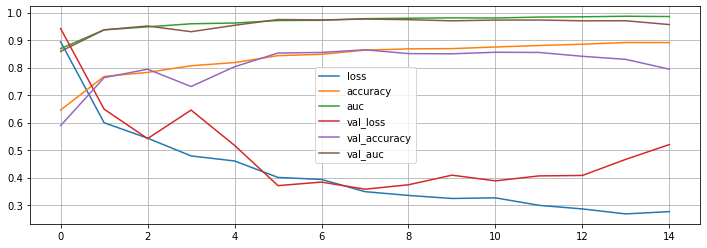

In [16]:
pd.DataFrame(history.history).plot(figsize=(12,4))
plt.grid(True)

In [17]:
#Per valutare il modello appresso sul test set utilizziamo il metodo evaluate.
model.evaluate(test_gen)

41/41 [==============================] - 96s 2s/step - loss: 0.5425 - accuracy: 0.7788 - auc: 0.9538


[0.5425212979316711, 0.7787948250770569, 0.9538032412528992]

In [18]:
#Mediante il metodo predict eseguiamo una predizione circa una nuova istanza.
test_pred=model.predict(test_gen)
test_pred

array([[0.00000000e+00, 1.05429324e-32, 1.00000000e+00, 0.00000000e+00],
       [1.22035507e-10, 3.42501998e-02, 9.65749800e-01, 4.82382745e-10],
       [7.45859696e-04, 3.33575726e-01, 6.41257269e-03, 6.59265876e-01],
       ...,
       [1.22910077e-02, 3.98176044e-01, 3.57439779e-02, 5.53788900e-01],
       [2.36254763e-02, 9.76128578e-01, 6.11100186e-05, 1.84829885e-04],
       [1.31899631e-03, 3.82672437e-02, 3.18734441e-04, 9.60095108e-01]],
      dtype=float32)

In [19]:
#finding the class by np.argmax() from each prediction
test_pred_class=[]
test_labels_class=[]
for i,pred in enumerate(test_pred):
    test_pred_class.append(np.int(np.argmax(pred)))
    
for i,pred in enumerate(test_labels):
    test_labels_class.append(np.int(np.argmax(pred)))

In [20]:
# print(test_pred_class)
# print(test_labels_class)

# Matrice di confusione
Nel campo del machine learning e in particolare del problema della classificazione statistica , una matrice di confusione , nota anche come matrice di errore, è un layout di tabella specifico che permette di visualizzare le prestazioni di un algoritmo, tipicamente di apprendimento supervisionato (in l'apprendimento non supervisionato viene solitamente chiamato matrice di corrispondenza ).

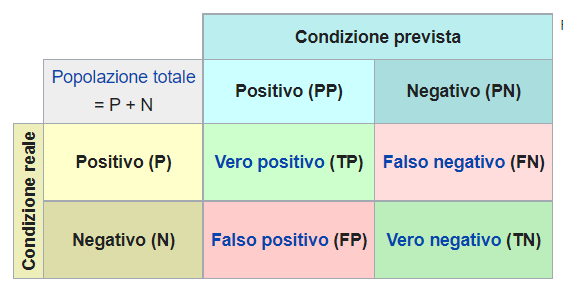

Ora possiamo semplicemente sommare ogni tipo di risultato, sostituirlo nel modello e creare una matrice di confusione che riassumerà in modo conciso i risultati del test del classificatore:

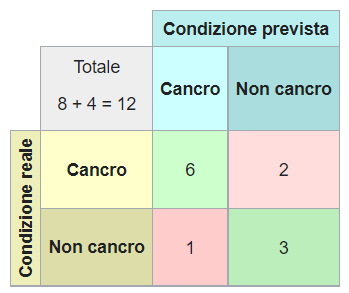

Questo problema è un problema di classificazione in cui un risultato positivo indica che il paziente ha un tumore. In questo scenario, devi pensare all'impatto dei seguenti errori:
 - Falsi positivi, dove il test dice che un paziente ha la malattia, ma in realtà non ce l'ha.
 - Falsi negativi, dove il test dice che un paziente non ha la malattia, ma in realtà ce l'ha.
 
Ovviamente entrambi i tipi di errore non sono auspicabili, ma qual è il peggiore? Dipende dal contesto. Nel nostro caso, essendo una malattia pericolosa per la vita che richiede un trattamento rapido, la riduzione al minimo dei falsi negativi ha la priorità.

In [21]:
#confusion matrix
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [22]:
cm = confusion_matrix(test_labels_class, test_pred_class)
labels=list(index_to_labels.values())
cm


array([[ 27, 126,  92,  55],
       [ 27, 141,  96,  42],
       [ 41, 151, 137,  76],
       [ 24, 113, 107,  56]], dtype=int64)

Confusion matrix, without normalization


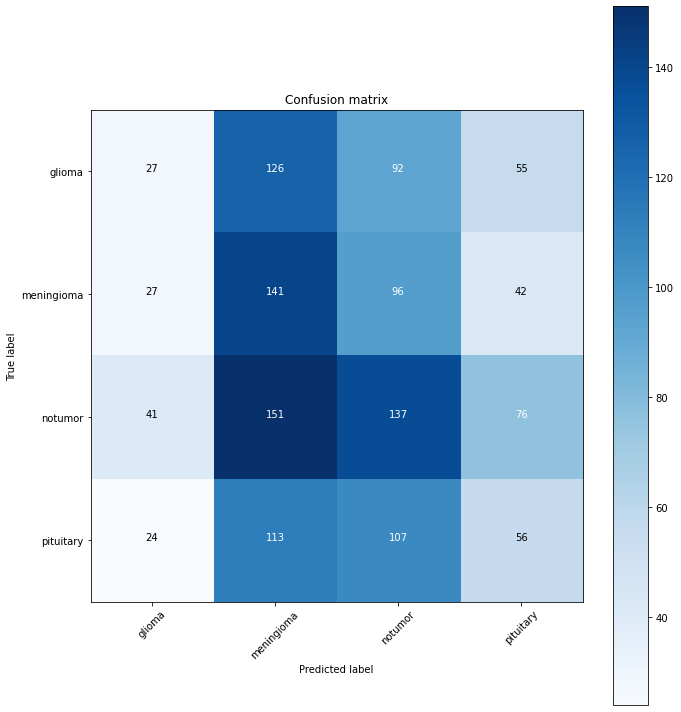

In [23]:
labels=list(index_to_labels.values())
plot_confusion_matrix(cm,labels)

In [24]:
roc_auc_score(test_labels,test_pred)

0.5090742960744492

In [25]:
path_to_label={}
for i,path in enumerate(test_paths):
    label = path.split('/')[-2]
    path_to_label[path]=label

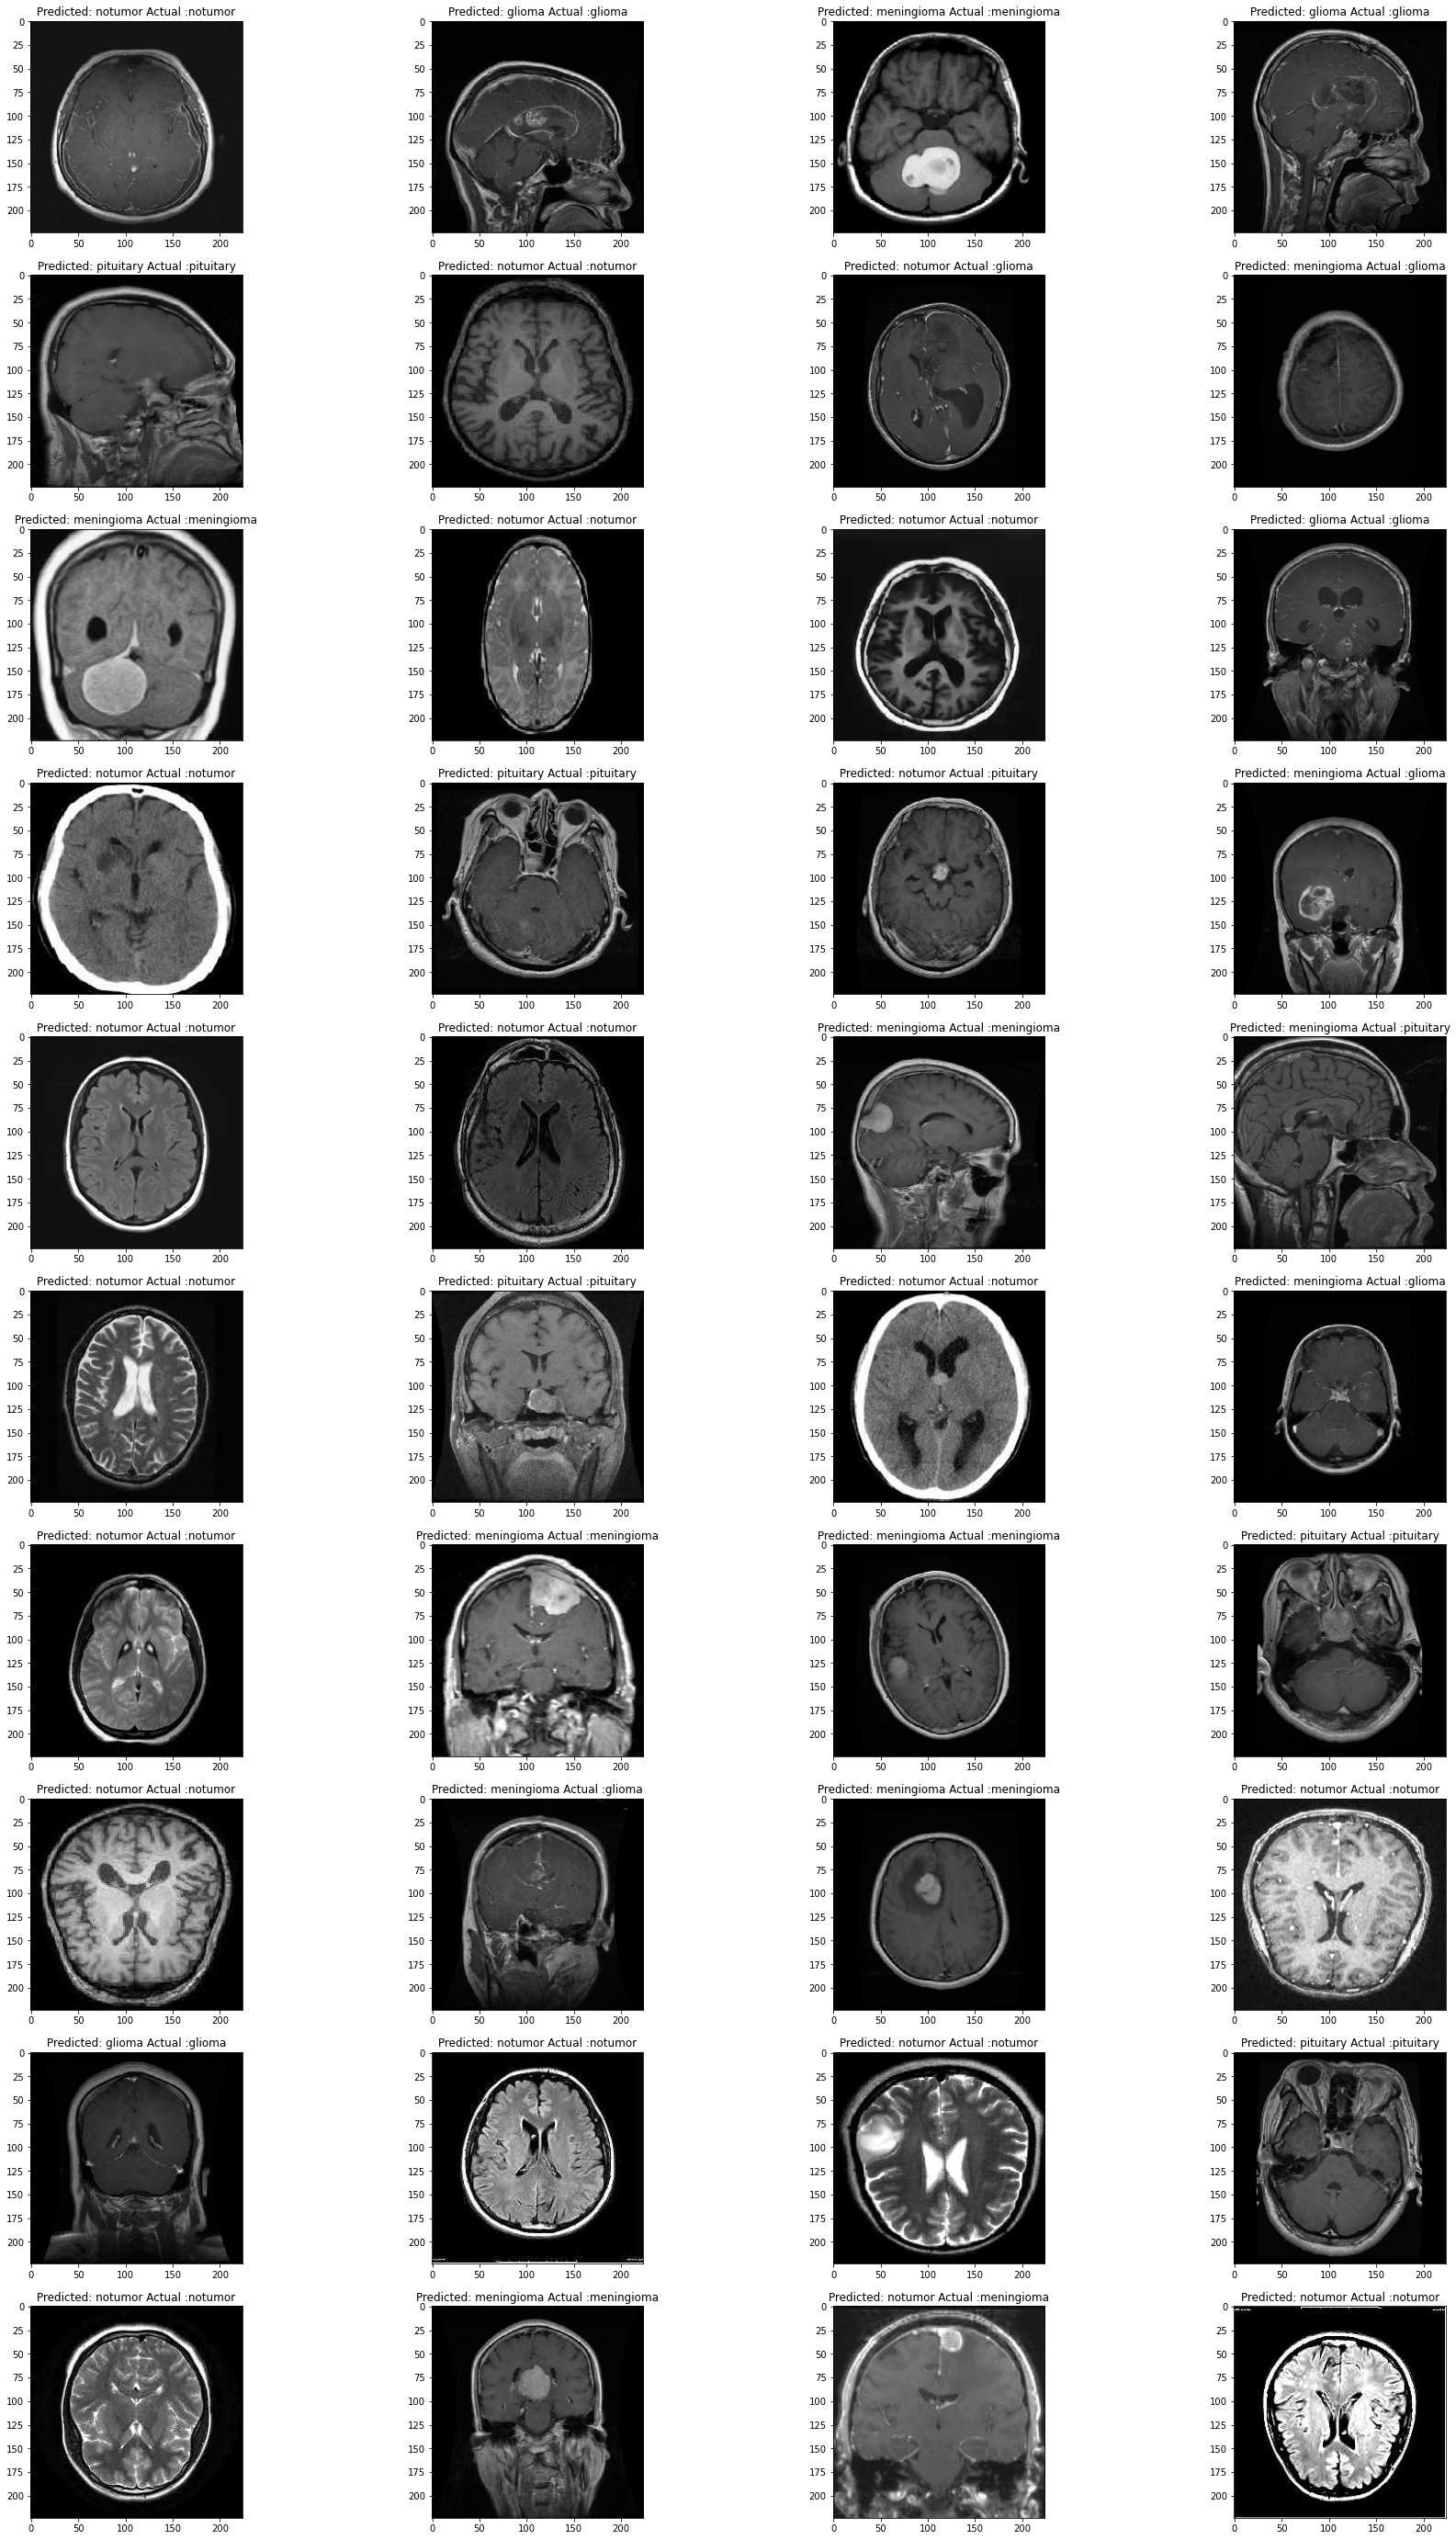

In [26]:
#Model Prediction
from PIL import Image

predictions=model.predict(test_gen)
fig = plt.figure(figsize=(30, 50))
columns = 4
rows = 10
for i in range(1, columns*rows +1):
    img = load_img(test_paths[i], target_size=(224, 224))
    img = img_to_array(img)
    img = np.array(img)/255.0
    img=np.reshape(img,(-1,224,224,3))
    pred=model.predict(img)
    index=np.argmax(pred)
    klass=index_to_labels[index] 
    actual=path_to_label[test_paths[i]]
    img=np.reshape(img,(224,224,3))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'Predicted: { klass} Actual :{actual}')
plt.show()

# VVG16

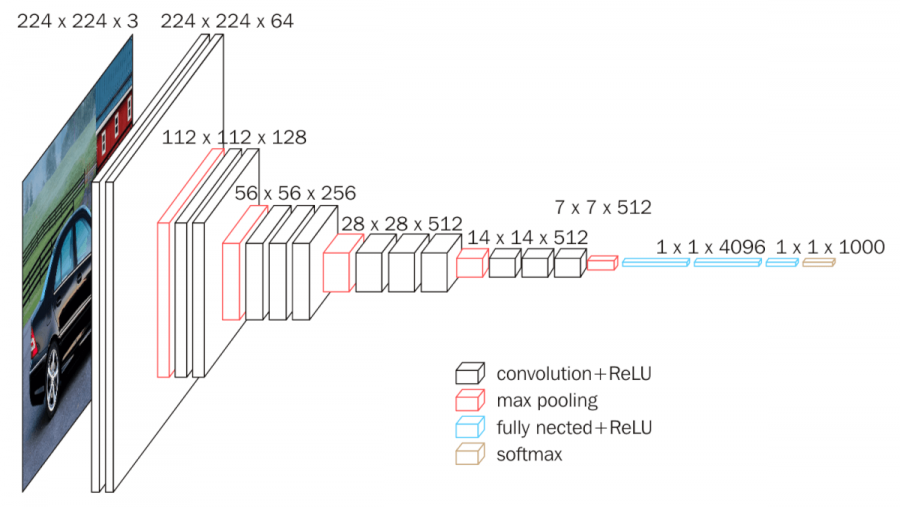

VGG16 è un'architettura di rete neurale di convoluzione (CNN) che è stata utilizzata per vincere il concorso ILSVR (Imagenet) nel 2014. È considerata una delle eccellenti architetture di modelli di visione fino ad oggi. La cosa più singolare di VGG16 è che invece di avere un gran numero di iperparametri si sono concentrati sull'avere strati di convoluzione del filtro 3x3 con uno stride 1 e hanno sempre usato lo stesso strato di riempimento e lo strato maxpool del filtro 2x2 di stride 2. Segue questa disposizione di convoluzione e livelli massimi di pool in modo coerente in tutta l'intera architettura. Alla fine ha 2 FC (strati completamente collegati) seguiti da un softmax per l'output. Il 16 in VGG16 si riferisce ad esso ha 16 strati che hanno pesi. Questa rete è una rete piuttosto grande e ha circa 138 milioni (circa) di parametri.

In [28]:
conv_base = keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

conv_base.trainable = True
model2 = Sequential([
    conv_base,
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation='sigmoid'),   
])

In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 14,815,044
Non-trainable params: 0
_________________________________________________________________


In [30]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy','AUC'])
history2 = model2.fit(train_gen, 
          epochs=10,
          validation_data=val_gen
         )
score = model2.evaluate(test_gen)
print(score)

Epoch 1/10
134/134 [==============================] - 3013s 23s/step - loss: 0.4245 - accuracy: 0.8445 - auc: 0.9504 - val_loss: 0.2124 - val_accuracy: 0.9209 - val_auc: 0.9851
Epoch 2/10
134/134 [==============================] - 3027s 23s/step - loss: 0.1435 - accuracy: 0.9489 - auc: 0.9903 - val_loss: 0.1412 - val_accuracy: 0.9503 - val_auc: 0.9896
Epoch 3/10
134/134 [==============================] - 2992s 22s/step - loss: 0.0883 - accuracy: 0.9690 - auc: 0.9935 - val_loss: 0.1263 - val_accuracy: 0.9601 - val_auc: 0.9910
Epoch 4/10
134/134 [==============================] - 2999s 22s/step - loss: 0.0654 - accuracy: 0.9755 - auc: 0.9959 - val_loss: 0.1453 - val_accuracy: 0.9573 - val_auc: 0.9888
Epoch 5/10
134/134 [==============================] - 3055s 23s/step - loss: 0.0492 - accuracy: 0.9855 - auc: 0.9975 - val_loss: 0.1149 - val_accuracy: 0.9601 - val_auc: 0.9942
Epoch 6/10
134/134 [==============================] - 3003s 22s/step - loss: 0.0371 - accuracy: 0.9881 - auc: 0.997

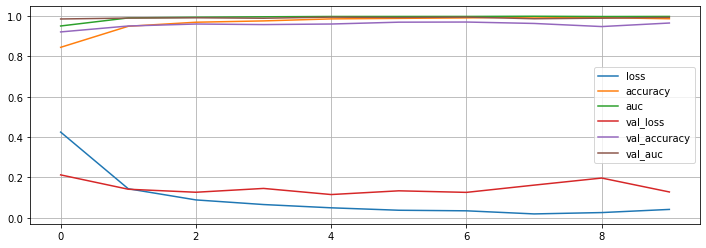

In [31]:
pd.DataFrame(history2.history).plot(figsize=(12,4))
plt.grid(True)

In [32]:
#Per valutare il modello appresso sul test set utilizziamo il metodo evaluate.
model2.evaluate(test_gen)

41/41 [==============================] - 225s 5s/step - loss: 0.1645 - accuracy: 0.9527 - auc: 0.9911


[0.1644771546125412, 0.952707827091217, 0.991132378578186]

In [33]:
#Mediante il metodo predict eseguiamo una predizione circa una nuova istanza.
test_pred2=model2.predict(test_gen)
test_pred2

array([[1.81974173e-02, 1.11785054e-01, 6.83292449e-02, 9.98069465e-01],
       [9.99204159e-01, 8.49276483e-02, 6.95600808e-02, 1.61859691e-02],
       [1.23441219e-04, 3.29824448e-01, 9.99993265e-01, 8.12500715e-04],
       ...,
       [9.37391222e-02, 1.00000000e+00, 4.48814671e-06, 1.62601471e-04],
       [4.97937202e-04, 1.00000000e+00, 3.02349627e-02, 2.21590062e-06],
       [7.14912415e-02, 4.89211679e-02, 6.06599450e-03, 9.99262035e-01]],
      dtype=float32)

In [34]:
#finding the class by np.argmax() from each prediction
test_pred_class2=[]
test_labels_class2=[]
for i,pred in enumerate(test_pred2):
    test_pred_class2.append(np.int(np.argmax(pred)))
    
for i,pred in enumerate(test_labels):
    test_labels_class2.append(np.int(np.argmax(pred)))

Confusion matrix, without normalization


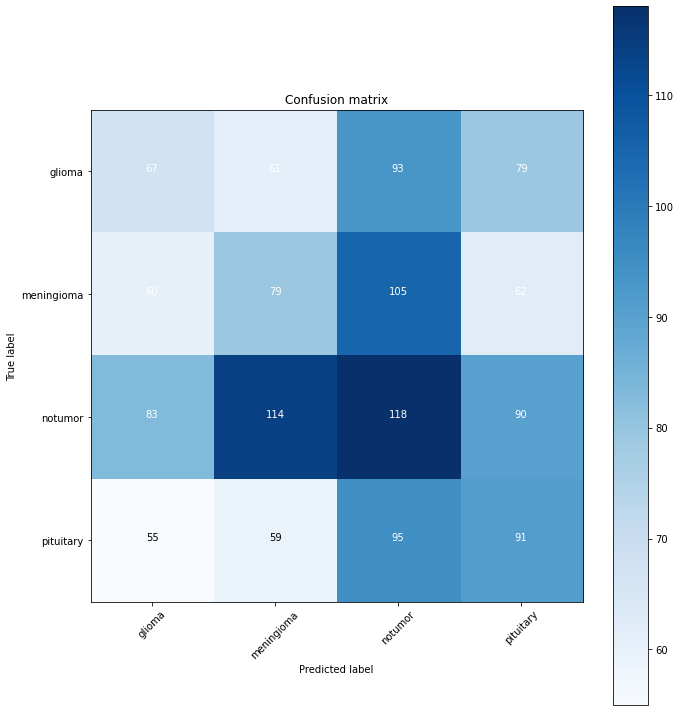

In [35]:
cm2 = confusion_matrix(test_labels_class2, test_pred_class2)
labels2 =list(index_to_labels.values())
plot_confusion_matrix(cm2,labels2)

In [36]:
roc_auc_score(test_labels,test_pred2)

0.5048196887586182